# **Pneumonia Detection Challenge**

### Context
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


### Data Description

## **Milestone - 1**

In [54]:
# include all the imports here
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pydicom
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, GlobalAveragePooling2D, Input)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam



### Step 1: Import the Data

#### Loading CSV files

In [9]:
# let us start with loading the csv files into dataframes
class_info = pd.read_csv('stage_2_detailed_class_info.csv')
sample_submission = pd.read_csv('stage_2_sample_submission.csv')
train_labels = pd.read_csv('stage_2_train_labels.csv')

# Display basic info about each of the dataframes
print('Detailed clas info shape:', class_info.shape)
print(class_info.head())
print("-" * 80)

print('Sample Submission shape:', sample_submission.shape)
print(sample_submission.head())
print("-" * 80)

print('Train Labels shape:', train_labels.shape)
print(train_labels.head())
print("-" * 80)

# distribution ov classes
print(class_info['class'].value_counts())

Detailed clas info shape: (30227, 2)
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
--------------------------------------------------------------------------------
Sample Submission shape: (3000, 2)
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100
--------------------------------------------------------------------------------
Trai

#### Reading DICOM images from the test and train folders

#### Check for duplicates and drop if any

In [22]:
# Check for duplicates in train_labels
duplicates_train_labels = train_labels.duplicated().sum()
print(f"\nDuplicate rows in train_labels: {duplicates_train_labels}")

# Check for duplicate patient IDs specifically
duplicate_patient_ids = train_labels['patientId'].duplicated().sum()
print(f"Duplicate patient IDs in train_labels: {duplicate_patient_ids}")

# Check for duplicates in class_info
duplicates_class_info = class_info.duplicated().sum()
print(f"Duplicate rows in detailed_class_info: {duplicates_class_info}")

# Check duplicates in sample submission (should ideally be none)
duplicates_sample_submission = sample_submission.duplicated().sum()
print(f"Duplicate rows in sample_submission: {duplicates_sample_submission}")

# Removing exact duplicates from train_labels
train_labels_cleaned = train_labels.drop_duplicates()
print(f"Rows before removing duplicates in train_labels: {len(train_labels)}")
print(f"Rows after removing duplicates in train_labels: {len(train_labels_cleaned)}")

# Removing exact duplicates from class_info
class_info_cleaned = class_info.drop_duplicates()
print(f"Rows before removing duplicates in class_info: {len(class_info)}")
print(f"Rows after removing duplicates in class_info: {len(class_info_cleaned)}")

# Sample submission typically should not have duplicates, remove if found
sample_submission_cleaned = sample_submission.drop_duplicates()
print(f"Rows before removing duplicates in sample_submission: {len(sample_submission)}")
print(f"Rows after removing duplicates in sample_submission: {len(sample_submission_cleaned)}")


Duplicate rows in train_labels: 0
Duplicate patient IDs in train_labels: 3543
Duplicate rows in detailed_class_info: 3543
Duplicate rows in sample_submission: 0
Rows before removing duplicates in train_labels: 30227
Rows after removing duplicates in train_labels: 30227
Rows before removing duplicates in class_info: 30227
Rows after removing duplicates in class_info: 26684
Rows before removing duplicates in sample_submission: 3000
Rows after removing duplicates in sample_submission: 3000


### Step 2: Map Training and Testing Images to Their Classes.

#### Merge the cleaned train_labels and class_info DataFrames based on patientId.

In [25]:
# Merge train_labels with class_info to have labels and bounding boxes together
train_data_merged = pd.merge(train_labels_cleaned, class_info_cleaned, on='patientId', how='left')


##### Shape and first few rows of the dataset

In [26]:
# Check merged data
print("Merged DataFrame shape:", train_data_merged.shape)
print(train_data_merged.head())

Merged DataFrame shape: (30227, 7)
                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


##### Statistical Summary of the Dataset

In [27]:
train_data_merged.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Missing Values

In [28]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0],
              'Percentage':(train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0]/train_data_merged.shape[0])*100})

,Count,Percentage
x,20672,68.389188
y,20672,68.389188
width,20672,68.389188
height,20672,68.389188


#### Inspect the distribution of class labels


Class distribution:
 class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


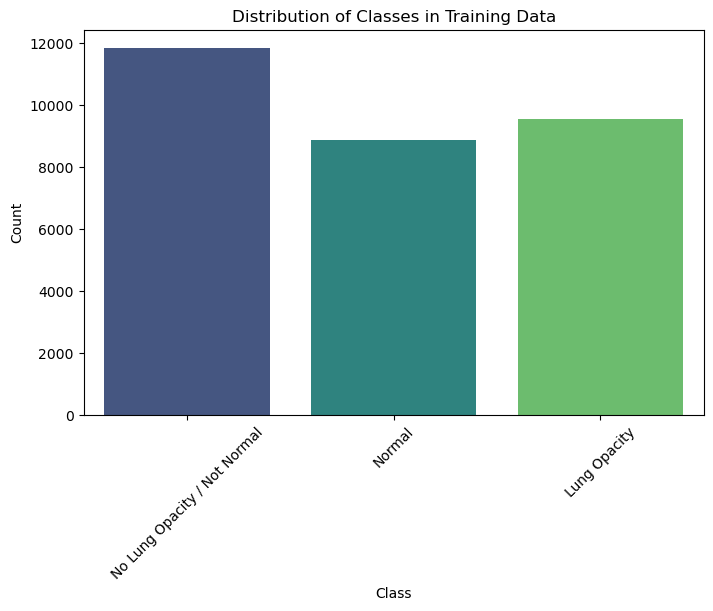

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution count
class_distribution = train_data_merged['class'].value_counts()
print("\nClass distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='viridis', hue='class')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


In [29]:
# Inspect the test set (sample submission file)
print("\nTest Set Sample Submission Preview:")
print(sample_submission_cleaned.head())



Test Set Sample Submission Preview:
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100


### Step 3: Map Training Images to Their Annotations

#### Map patient IDs to their bounding boxes

In [30]:
# Group annotations by patientId clearly
annotations_grouped = train_labels_cleaned.groupby('patientId')

# Example: Display annotations for a specific patient clearly
sample_patient = train_labels_cleaned[train_labels_cleaned['Target'] == 1]['patientId'].iloc[0]

print(f"\nBounding Boxes for patientId '{sample_patient}':")
print(annotations_grouped.get_group(sample_patient))



Bounding Boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
                              patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1


#### Create a convenient annotation dictionary

In [31]:
# Create dictionary mapping patientId to list of bounding boxes (coordinates)
bbox_dict = {}

for patientId, group in annotations_grouped:
    bboxes = group[['x', 'y', 'width', 'height', 'Target']].values
    bbox_dict[patientId] = bboxes

# Verify clearly
print(f"Bounding boxes for patientId '{sample_patient}':")
print(bbox_dict[sample_patient])


Bounding boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
[[264. 152. 213. 379.   1.]
 [562. 152. 256. 453.   1.]]


#### Summary of Bounding Box Data

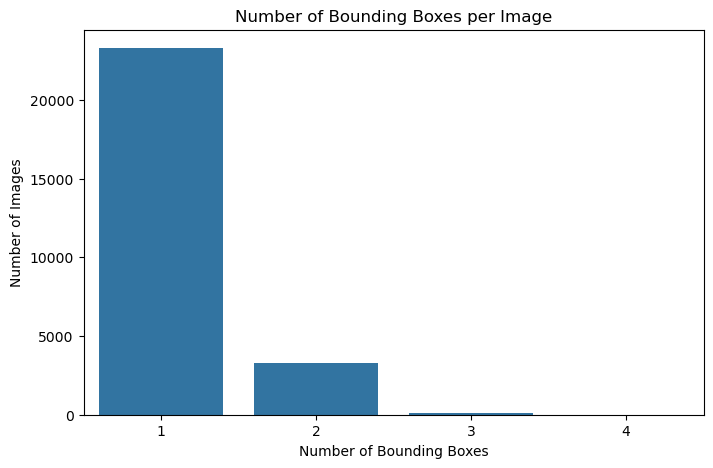

In [33]:
# Count number of bounding boxes per image
bbox_counts = annotations_grouped.size()

# Distribution clearly shown
plt.figure(figsize=(8,5))
sns.countplot(x=bbox_counts)
plt.title("Number of Bounding Boxes per Image")
plt.xlabel("Number of Bounding Boxes")
plt.ylabel("Number of Images")
plt.show()


### Step 4: Preprocessing and Visualization of Different Classes

In [39]:
class DicomProcessor:
    def __init__(self, dir_path: str):
        self.dir_path = dir_path

    def get_file_path(self, patient_id: str) -> str:
        file_path = os.path.join(self.dir_path, f"{patient_id}.dcm")
        return file_path

    def read_dicom_file(self, patient_id: str) -> np.ndarray:
        file_path = self.get_file_path(patient_id)
        ds = pydicom.dcmread(file_path)
        return ds.pixel_array

    def convert_to_grayscale(self, image: np.ndarray) -> np.ndarray:
        # Normalize pixel values to be between 0 and 1
        image = image / np.max(image)

        # Convert to grayscale if necessary
        if image.ndim > 2:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        return image

    def get_resized_dicom_image(self, patient_id: str, size=256) -> np.ndarray:
        # read the dicom file
        image = self.read_dicom_file(patient_id)

        image = self.convert_to_grayscale(image)

        # Resize to the specified size
        image = cv2.resize(image, (size, size))

        # Expand dimensions for CNN input (add channel dimension)
        image = np.expand_dims(image, axis=-1)
        return image

# Ensure reproducibility
random.seed(42)

# Define sampling function
def sample_patients_from_class(class_name, n=3):
    """Sample n patient IDs from a given class."""
    patients = class_info[class_info['class'] == class_name]['patientId'].tolist()
    return random.sample(patients, n)

# Function for clean plotting
def plot_class_samples(patients, axs_row, class_label):
    for ax, patient_id in zip(axs_row, patients):
        img = train_images.get_resized_dicom_image(patient_id)
        ax.imshow(img[:, :, 0], cmap='gray')
        ax.set_title(f"{class_label}\n({patient_id[:8]}...)", fontsize=10)
        ax.axis('off')

 #### **Instantiate the Processor**

In [40]:
test_images_dir = 'stage_2_test_images'
train_images_dir = 'stage_2_train_images'

test_images = DicomProcessor(test_images_dir)
train_images = DicomProcessor(train_images_dir)

#### **Check Missing Bounding Boxes**

In [43]:
no_bbox_images = train_labels_cleaned[train_labels_cleaned['Target'] == 0]['patientId'].unique()

print(f"Number of images without bounding boxes (no pneumonia): {len(no_bbox_images)}")
print(f"Example patientIds without bounding boxes: {no_bbox_images[:5]}")


Number of images without bounding boxes (no pneumonia): 20672
Example patientIds without bounding boxes: ['0004cfab-14fd-4e49-80ba-63a80b6bddd6'
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd'
 '00322d4d-1c29-4943-afc9-b6754be640eb'
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5'
 '00569f44-917d-4c86-a842-81832af98c30']


#### **Visualizing samples from each class:**

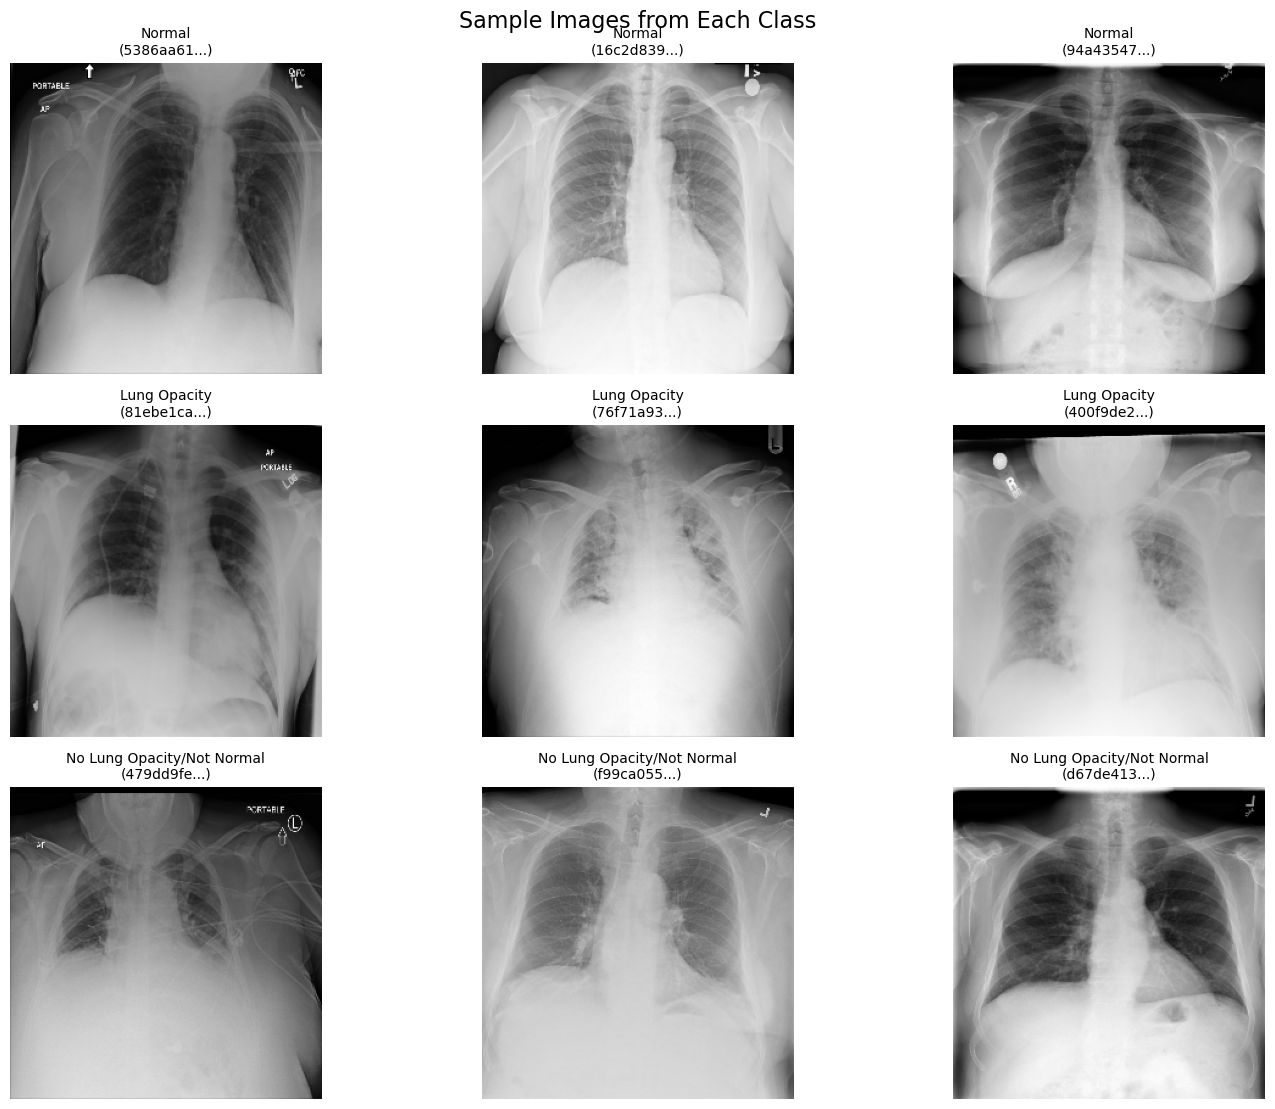

In [41]:
# Sample patient IDs from each class clearly
normal_patients = sample_patients_from_class('Normal')
opacity_patients = sample_patients_from_class('Lung Opacity')
not_normal_patients = sample_patients_from_class('No Lung Opacity / Not Normal')

# Plot samples from each class clearly
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Sample Images from Each Class', fontsize=16, y=0.92)

# Plot each row explicitly for clarity
plot_class_samples(normal_patients, axs[0], "Normal")
plot_class_samples(opacity_patients, axs[1], "Lung Opacity")
plot_class_samples(not_normal_patients, axs[2], "No Lung Opacity/Not Normal")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### **Inspect Class Distribution**

C:\Users\nkpat\AppData\Local\Temp\ipykernel_20676\3668924464.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=train_data_merged, palette='viridis')


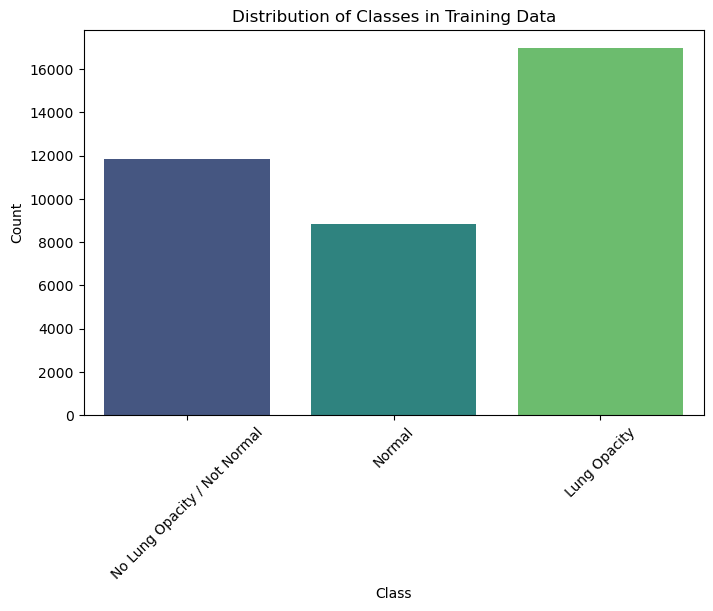

In [44]:
# Merge for clear visualization
train_data_merged = pd.merge(train_labels_cleaned, class_info, on='patientId', how='left')

# Clearly visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='viridis')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


### Step 5: Display Images with Bounding Boxes

#### **Setup Helper Function to Draw Bounding Boxes**

In [45]:
def draw_bounding_boxes(image: np.ndarray, boxes: np.ndarray, color=(255, 0, 0)) -> np.ndarray:
    """
    Draw bounding boxes on a grayscale image.
    :param image: 2D or 3D NumPy array of image
    :param boxes: Array of [x, y, width, height, Target]
    :param color: RGB color tuple for bounding box (ignored for grayscale display)
    :return: Image with bounding boxes drawn (squeezed to 2D)
    """
    img_copy = image.copy().squeeze()
    img_copy = cv2.cvtColor((img_copy * 255).astype('uint8'), cv2.COLOR_GRAY2BGR)

    for box in boxes:
        x, y, w, h, target = box
        if target == 1:  # Draw only for pneumonia cases
            top_left = (int(x), int(y))
            bottom_right = (int(x + w), int(y + h))
            cv2.rectangle(img_copy, top_left, bottom_right, color, 2)

    return img_copy


#### **Sample and Display Images with Bounding Boxes**

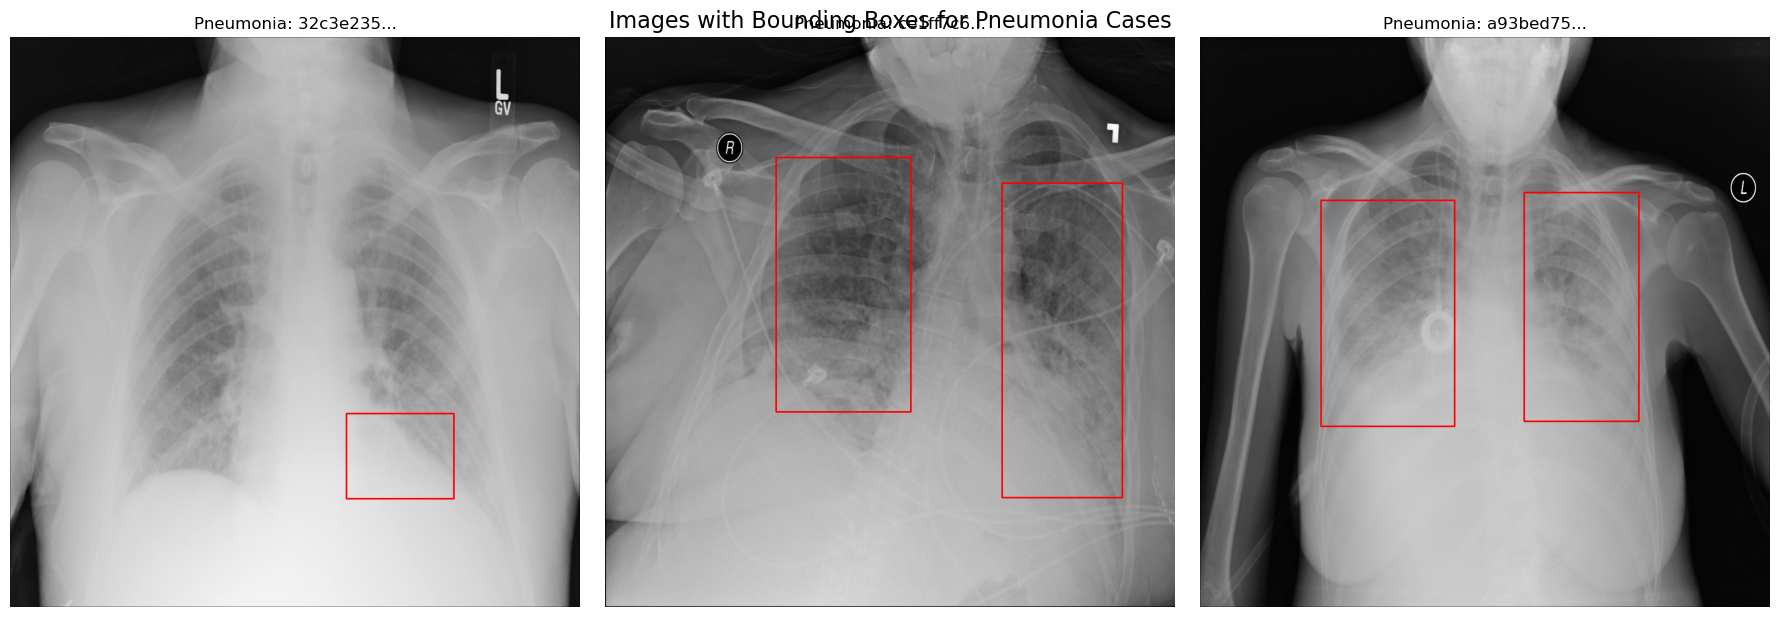

In [46]:
# Filter patients with pneumonia
pneumonia_patients = train_labels_cleaned[train_labels_cleaned['Target'] == 1]['patientId'].unique()
sample_pneumonia_patients = random.sample(list(pneumonia_patients), 3)

plt.figure(figsize=(18, 6))

for idx, patient_id in enumerate(sample_pneumonia_patients):
    # Get image
    image = train_images.read_dicom_file(patient_id)
    image = train_images.convert_to_grayscale(image)

    # Get bounding boxes for this patient
    boxes = train_labels_cleaned[train_labels_cleaned['patientId'] == patient_id][['x', 'y', 'width', 'height', 'Target']].values

    # Draw boxes
    image_with_boxes = draw_bounding_boxes(image, boxes)

    # Display
    plt.subplot(1, 3, idx + 1)
    plt.imshow(image_with_boxes, cmap='gray')
    plt.title(f"Pneumonia: {patient_id[:8]}...")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Images with Bounding Boxes for Pneumonia Cases", fontsize=16, y=1.02)
plt.show()


### Step 6: Design, Train, and Test Basic CNN Models

#### **Encode Labels and Prepare Train/Validation Split**

In [55]:
# Prepare class labels
df = class_info_cleaned.copy()
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

# Train/Validation split
train_ids, val_ids, train_labels, val_labels = train_test_split(
    df['patientId'], df['label'], stratify=df['label'], test_size=0.2, random_state=42)


#### **Data Generators**

In [56]:

class PneumoniaDataGenerator(Sequence):
    def __init__(self, patient_ids, labels, processor, batch_size=32, image_size=256, shuffle=True):
        self.patient_ids = list(patient_ids)
        self.labels = list(labels)
        self.processor = processor
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.patient_ids) // self.batch_size

    def __getitem__(self, index):
        ids = self.patient_ids[index * self.batch_size:(index + 1) * self.batch_size]
        y = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.array([self.processor.get_resized_dicom_image(pid, size=self.image_size) for pid in ids])
        y = to_categorical(y, num_classes=3)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.patient_ids, self.labels))
            random.shuffle(temp)
            self.patient_ids, self.labels = zip(*temp)


In [57]:
class MobileNetDataGenerator(PneumoniaDataGenerator):
    def __getitem__(self, index):
        X, y = super().__getitem__(index)
        X = np.repeat(X, 3, axis=-1)  # convert (H, W, 1) -> (H, W, 3)
        return X, y


#### **ModelBuilder**

In [58]:

class ModelBuilder:
    def __init__(self, input_shape, num_classes=3):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_basic_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_deeper_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_mobilenetv2(self):
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
        base_model.trainable = False

        inputs = Input(shape=(256, 256, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model


#### **TrainingManager**

In [59]:
class TrainingManager:
    def __init__(self, processor, train_ids, train_labels, val_ids, val_labels, batch_size=32):
        self.processor = processor
        self.train_ids = train_ids
        self.train_labels = train_labels
        self.val_ids = val_ids
        self.val_labels = val_labels
        self.batch_size = batch_size

    def get_generator(self, model_type):
        if model_type == 'MobileNetV2':
            return (
                MobileNetDataGenerator(self.train_ids, self.train_labels, self.processor, batch_size=self.batch_size),
                MobileNetDataGenerator(self.val_ids, self.val_labels, self.processor, batch_size=self.batch_size)
            )
        else:
            return (
                PneumoniaDataGenerator(self.train_ids, self.train_labels, self.processor, batch_size=self.batch_size),
                PneumoniaDataGenerator(self.val_ids, self.val_labels, self.processor, batch_size=self.batch_size)
            )

    def train_model(self, model_type: str, epochs=5):
        input_shape = (256, 256, 1) if model_type != 'MobileNetV2' else (256, 256, 3)
        builder = ModelBuilder(input_shape=input_shape)

        if model_type == 'BasicCNN':
            model = builder.build_basic_cnn()
        elif model_type == 'DeeperCNN':
            model = builder.build_deeper_cnn()
        elif model_type == 'MobileNetV2':
            model = builder.build_mobilenetv2()
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        train_gen, val_gen = self.get_generator(model_type)

        print(f"\n🔧 Training: {model_type}")
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)
        return model, history


#### **Train All Models**

In [60]:
trainer = TrainingManager(
    processor=train_images,
    train_ids=train_ids,
    train_labels=train_labels,
    val_ids=val_ids,
    val_labels=val_labels
)

models = {}
histories = {}

for model_type in ['BasicCNN', 'DeeperCNN', 'MobileNetV2']:
    model, history = trainer.train_model(model_type=model_type, epochs=5)
    models[model_type] = model
    histories[model_type] = history



🔧 Training: BasicCNN
Epoch 1/5
667/667 [==============================] - 749s 1s/step - loss: 0.9329 - accuracy: 0.5394 - val_loss: 0.8811 - val_accuracy: 0.5612
Epoch 2/5
667/667 [==============================] - 757s 1s/step - loss: 0.8729 - accuracy: 0.5731 - val_loss: 0.8295 - val_accuracy: 0.5994
Epoch 3/5
667/667 [==============================] - 728s 1s/step - loss: 0.8433 - accuracy: 0.5955 - val_loss: 0.8151 - val_accuracy: 0.6082
Epoch 4/5
667/667 [==============================] - 736s 1s/step - loss: 0.8185 - accuracy: 0.6082 - val_loss: 0.7942 - val_accuracy: 0.6258
Epoch 5/5
667/667 [==============================] - 741s 1s/step - loss: 0.7888 - accuracy: 0.6270 - val_loss: 0.7876 - val_accuracy: 0.6329

🔧 Training: DeeperCNN
Epoch 1/5
667/667 [==============================] - 790s 1s/step - loss: 0.9503 - accuracy: 0.5174 - val_loss: 0.8581 - val_accuracy: 0.5787
Epoch 2/5
667/667 [==============================] - 805s 1s/step - loss: 0.8711 - accuracy: 0.5746 - v

#### **Plot Validation Accuracy Comparison**

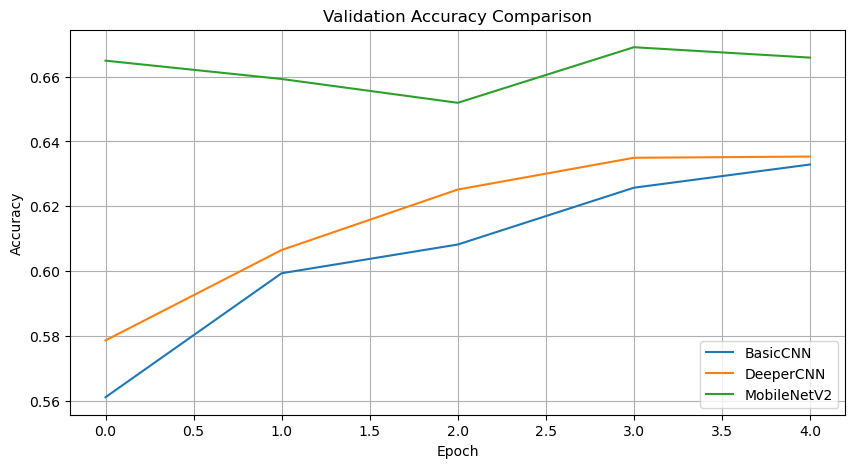

In [61]:

plt.figure(figsize=(10,5))
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f"{name}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Step 7: Interim Report